In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tqdm import tqdm

# 1. Набор данных CAMUS

In [2]:
from echo_lv.data import LV_CAMUS_Dataset

In [3]:
data_lv = LV_CAMUS_Dataset(classes={0, 1},
                           patient_qualities={'Good', 'Medium', 'Poor'},
                           heart_states={'ED', 'ES'},
                           views={'2CH', '4CH'},
                           image_qualities={'Good', 'Medium', 'Poor'},
                           shuffle=False,
                          )

In [5]:
print(data_lv.get_num_all_frames() + 2771)

22003


## 1.1 Статистики по пациентам

In [4]:
data_lv.df_patients['quality'].value_counts() / len(data_lv.df_patients)

Medium    0.462222
Good      0.351111
Poor      0.186667
Name: quality, dtype: float64

In [5]:
ef_dist = {'<=45': 0, '>=55': 0, 'else': 0}
ef_dist['<=45'] = len(data_lv.df_patients[(data_lv.df_patients['ef'] <= 45)]) / len(data_lv.df_patients)
ef_dist['>=55'] = len(data_lv.df_patients[(data_lv.df_patients['ef'] >= 55)]) / len(data_lv.df_patients)
ef_dist['else'] = len(data_lv.df_patients[(data_lv.df_patients['ef'] > 45) & (data_lv.df_patients['ef'] < 55)]) / len(data_lv.df_patients)
for key in ef_dist.keys():
    print(key, '   ', '{:.3f}'.format(ef_dist[key]))

<=45     0.264
>=55     0.447
else     0.289


## 1.2 Статистики по изображениям

In [6]:
data_lv.df_images['img_shape'].value_counts().head(10) / 1800

(630, 1038)    0.144444
(551, 908)     0.111111
(512, 843)     0.100000
(590, 973)     0.072222
(669, 1103)    0.055556
(748, 1232)    0.054444
(669, 1102)    0.050000
(591, 973)     0.046667
(472, 779)     0.038889
(708, 1168)    0.037778
Name: img_shape, dtype: float64

In [7]:
260 / 1800

0.14444444444444443

In [8]:
data_lv.df_images['img_shape'].max()

(1181, 1945)

In [9]:
data_lv.df_images['img_shape'].min()

(323, 649)

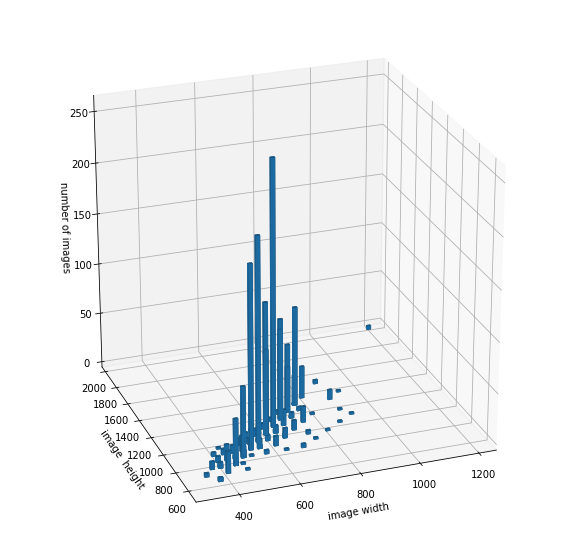

In [39]:
w, h, n = [], [], []
for it in data_lv.df_images['img_shape'].value_counts().iteritems():
    w.append(it[0][0])
    h.append(it[0][1])
    n.append(it[1])

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.bar3d(w, h, np.zeros(len(w)), 15*np.ones(len(w)), 15*np.ones(len(w)), n, zsort='average')
# ax.set_xlim(0)
# ax.set_ylim(0)
ax.set_xlabel('image width')
ax.set_ylabel('image  height')
ax.set_zlabel('number of images')
# ax.set_xlabel('ширина изображения')
# ax.set_ylabel('высота изображения')
# ax.set_zlabel('количество кадров')
ax.view_init(25, 250)
plt.savefig('imgs/dist_size_camus.png', dpi=300, bbox_inches='tight', pad_inches=0)

In [40]:
data_lv.df_images['quality'].value_counts()

Good      916
Medium    682
Poor      202
Name: quality, dtype: int64

In [11]:
data_lv.df_images['quality'].value_counts() / len(data_lv.df_images)

Good      0.508889
Medium    0.378889
Poor      0.112222
Name: quality, dtype: float64

In [12]:
data_lv.df_images

,patient,heart_state,view,quality,img_shape,img_name,msk_name
0,patient0001,ED,2CH,Good,"(549, 778)",patient0001_2CH_ED.mhd,patient0001_2CH_ED_gt.mhd
1,patient0001,ES,2CH,Good,"(549, 778)",patient0001_2CH_ES.mhd,patient0001_2CH_ES_gt.mhd
2,patient0001,ED,4CH,Good,"(549, 778)",patient0001_4CH_ED.mhd,patient0001_4CH_ED_gt.mhd
3,patient0001,ES,4CH,Good,"(549, 778)",patient0001_4CH_ES.mhd,patient0001_4CH_ES_gt.mhd
4,patient0002,ED,2CH,Medium,"(748, 1167)",patient0002_2CH_ED.mhd,patient0002_2CH_ED_gt.mhd
...,...,...,...,...,...,...,...
1795,patient0449,ES,4CH,Medium,"(433, 714)",patient0449_4CH_ES.mhd,patient0449_4CH_ES_gt.mhd
1796,patient0450,ED,2CH,Good,"(869, 1232)",patient0450_2CH_ED.mhd,patient0450_2CH_ED_gt.mhd
1797,patient0450,ES,2CH,Good,"(869, 1232)",patient0450_2CH_ES.mhd,patient0450_2CH_ES_gt.mhd
1798,patient0450,ED,4CH,Good,"(748, 1232)",patient0450_4CH_ED.mhd,patient0450_4CH_ED_gt.mhd


## Кадры и маски

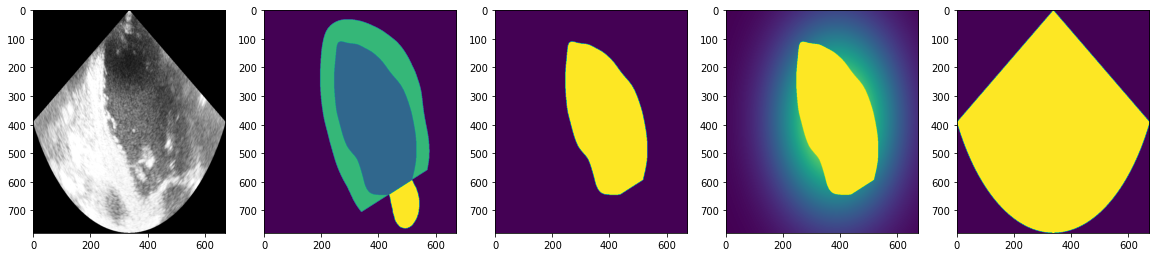

In [33]:
img, msk, full_msk, weighted_msk, segment_mask, *_ = data_lv[204]
plt.figure(figsize=(20,7))
plt.subplot(151)
plt.imshow(np.squeeze(img), cmap=plt.cm.gray)
cv2.imwrite('imgs/us_image_camus.png', (np.squeeze(img)*255).astype(np.uint8))
plt.subplot(152)
plt.imshow(np.squeeze(full_msk))
cv2.imwrite('imgs/us_mask_camus.png', (np.squeeze(full_msk) / np.max(full_msk) * 255).astype(np.uint8))
plt.subplot(153)
plt.imshow(np.squeeze(msk))
plt.subplot(154)
plt.imshow(np.squeeze(weighted_msk))
plt.subplot(155)
plt.imshow(segment_mask)

In [32]:
from skimage.transform import resize
sz = []
for it in tqdm(range(len(data_lv)), total=len(data_lv)):
    img, msk, full_msk, weighted_msk, segment_mask, *_ = data_lv[it]
    segment_mask = resize(segment_mask, (256, 256), preserve_range=True, anti_aliasing=False, order=0)
    area = np.sum(segment_mask)
    if area > 39000:
        break
    sz.append(area)

 11%|█▏        | 204/1800 [00:08<01:03, 25.27it/s]


In [36]:
l = []
l += ['a', 'b', 'c']
l += ['a', 'b', 'c']

In [37]:
l

['a', 'b', 'c', 'a', 'b', 'c']

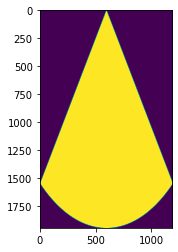

In [27]:
plt.imshow(segment_mask)

(array([  82.,   86., 1542.,    0.,   70.,    0.,    8.,    0.,    0.,
          12.]),
 array([34022. , 34578.4, 35134.8, 35691.2, 36247.6, 36804. , 37360.4,
        37916.8, 38473.2, 39029.6, 39586. ]),
 <a list of 10 Patch objects>)

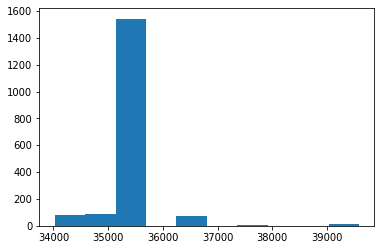

In [31]:
plt.hist(sz)

# 2. Набор данных ЕКБ

In [18]:
from src.data import LV_EKB_Dataset

In [19]:
data_lv = LV_EKB_Dataset(dataset_path='datasets/us_ekb',img_size=(256,256))

Dataset is correct.


## 2.1 Статистика по пациентам

In [20]:
data_lv.df_patients

,patient,category,img_shape,num_frames
0,01,DKMP,"(600, 800)",34
1,02,DKMP,"(644, 832)",29
2,03,DKMP,"(644, 832)",35
3,04,DKMP,"(600, 800)",34
4,05,DKMP,"(600, 800)",63
...,...,...,...,...
92,48,Pathology_Old,"(480, 640)",27
93,49,Pathology_Old,"(480, 640)",28
94,50,Pathology_Old,"(240, 320)",35
95,51,Pathology_Old,"(480, 640)",29


In [21]:
data_lv.df_patients['category'].value_counts() / len(data_lv.df_patients)

Pathology_Old    0.546392
Norma_Old        0.257732
Norma            0.144330
DKMP             0.051546
Name: category, dtype: float64

In [22]:
data_lv.df_images['img_shape'].value_counts() / len(data_lv.df_images)

(480, 640)    0.524720
(600, 800)    0.252616
(240, 320)    0.199567
(644, 832)    0.023096
Name: img_shape, dtype: float64

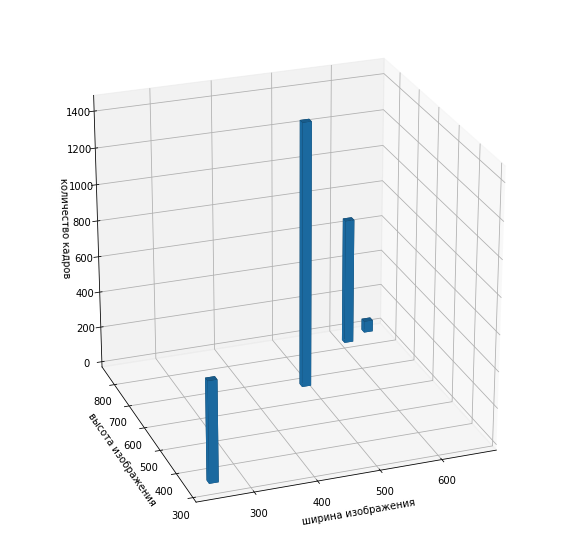

In [23]:
w, h, n = [], [], []
for it in data_lv.df_images['img_shape'].value_counts().iteritems():
    w.append(it[0][0])
    h.append(it[0][1])
    n.append(it[1])
    
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.bar3d(w, h, np.zeros(len(w)), 15*np.ones(len(w)), 15*np.ones(len(w)), n, zsort='average')
# ax.set_xlim(0)
# ax.set_ylim(0)
ax.set_xlabel('ширина изображения')
ax.set_ylabel('высота изображения')
ax.set_zlabel('количество кадров')
ax.view_init(25, 250)
plt.savefig('imgs/dist_size_usekb.png', dpi=300)

True

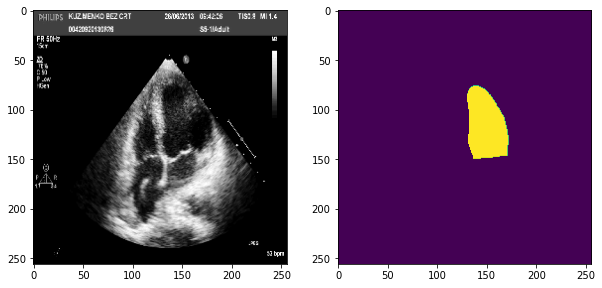

In [24]:
img, msk = data_lv[5]
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img, cmap=plt.cm.gray)
cv2.imwrite('imgs/us_image_ekb.png', img)
plt.subplot(122)
plt.imshow(msk)
cv2.imwrite('imgs/us_mask_ekb.png', msk)

In [25]:
for index, obj in lv.df_images.iterrows():
    print(obj)
    break

NameError: name 'lv' is not defined

In [ ]:
lv.df_patients['e'] = None

In [ ]:
config = configparser.ConfigParser()
config.read('../datasets/us_camus/training/patient0001/info_2CH.cfg')

In [ ]:
image_itk.GetMetaData('Quality')